# Step 1

In [5]:
import sqlite3
import pandas as pd
from pathlib import Path

# Database path
db_path = r"D:\Documents\daily\E_Plus_2040_py\output\49d99568-e595-46aa-9fc0-22f0ddfdeb94\Sim_Results\2020\simulation_bldg0_4136733.sql"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"Connected to: {Path(db_path).name}")
print("=" * 80)

# 1. Get all table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
table_names = [table[0] for table in tables]

print(f"\nFound {len(table_names)} tables:")
for i, table in enumerate(table_names, 1):
    print(f"  {i}. {table}")

print("\n" + "=" * 80)

# 2. For each table, show schema and row count
for table_name in table_names:
    print(f"\nTable: {table_name}")
    print("-" * 40)
    
    # Get table schema
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    
    print("Columns:")
    for col in columns:
        col_id, name, dtype, notnull, default, pk = col
        pk_text = " (PRIMARY KEY)" if pk else ""
        print(f"  - {name} ({dtype}){pk_text}")
    
    # Get row count
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    row_count = cursor.fetchone()[0]
    print(f"\nRow count: {row_count:,}")
    
    # Show first 5 rows if table has data
    if row_count > 0:
        print(f"\nFirst 5 rows:")
        df = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 5", conn)
        print(df.to_string())
    
    print("\n" + "=" * 80)

# Close connection
conn.close()
print("\nDatabase connection closed.")

Connected to: simulation_bldg0_4136733.sql

Found 36 tables:
  1. Simulations
  2. EnvironmentPeriods
  3. Errors
  4. Time
  5. Zones
  6. ZoneLists
  7. ZoneGroups
  8. ZoneInfoZoneLists
  9. Schedules
  10. Materials
  11. Constructions
  12. ConstructionLayers
  13. Surfaces
  14. ReportDataDictionary
  15. ReportData
  16. ReportExtendedData
  17. NominalPeople
  18. NominalLighting
  19. NominalElectricEquipment
  20. NominalGasEquipment
  21. NominalSteamEquipment
  22. NominalHotWaterEquipment
  23. NominalOtherEquipment
  24. NominalBaseboardHeaters
  25. NominalInfiltration
  26. NominalVentilation
  27. ZoneSizes
  28. SystemSizes
  29. ComponentSizes
  30. RoomAirModels
  31. DaylightMaps
  32. DaylightMapHourlyReports
  33. DaylightMapHourlyData
  34. StringTypes
  35. Strings
  36. TabularData


Table: Simulations
----------------------------------------
Columns:
  - SimulationIndex (INTEGER) (PRIMARY KEY)
  - EnergyPlusVersion (TEXT)
  - TimeStamp (TEXT)
  - NumTimesteps

# step 2

ENERGYPLUS SIMULATION DATA ANALYSIS

1. ENERGY CONSUMPTION ANALYSIS

Total simulation days with electricity data: 365

Monthly Electricity Consumption Summary:
         sum  mean   std  count
Month                          
1      59.99  1.94  0.27     31
2      54.65  1.95  0.28     28
3      61.21  1.97  0.29     31
4      58.21  1.94  0.27     30
5      59.99  1.94  0.27     31
6      59.43  1.98  0.29     30
7      59.99  1.94  0.27     31
8      60.60  1.95  0.28     31
9      58.82  1.96  0.28     30
10     59.99  1.94  0.27     31
11     58.82  1.96  0.28     30
12     60.60  1.95  0.28     31

Total Electricity Consumption: 712.27 kWh
Average Daily Consumption: 1.95 kWh/day

2. HEATING AND COOLING ENERGY ANALYSIS
Days with heating data: 12
Days with cooling data: 12

3. ZONE TEMPERATURE ANALYSIS

Zone Temperature Summary (°C):
                                                     mean    min    max   std
Zone                 Variable                                              

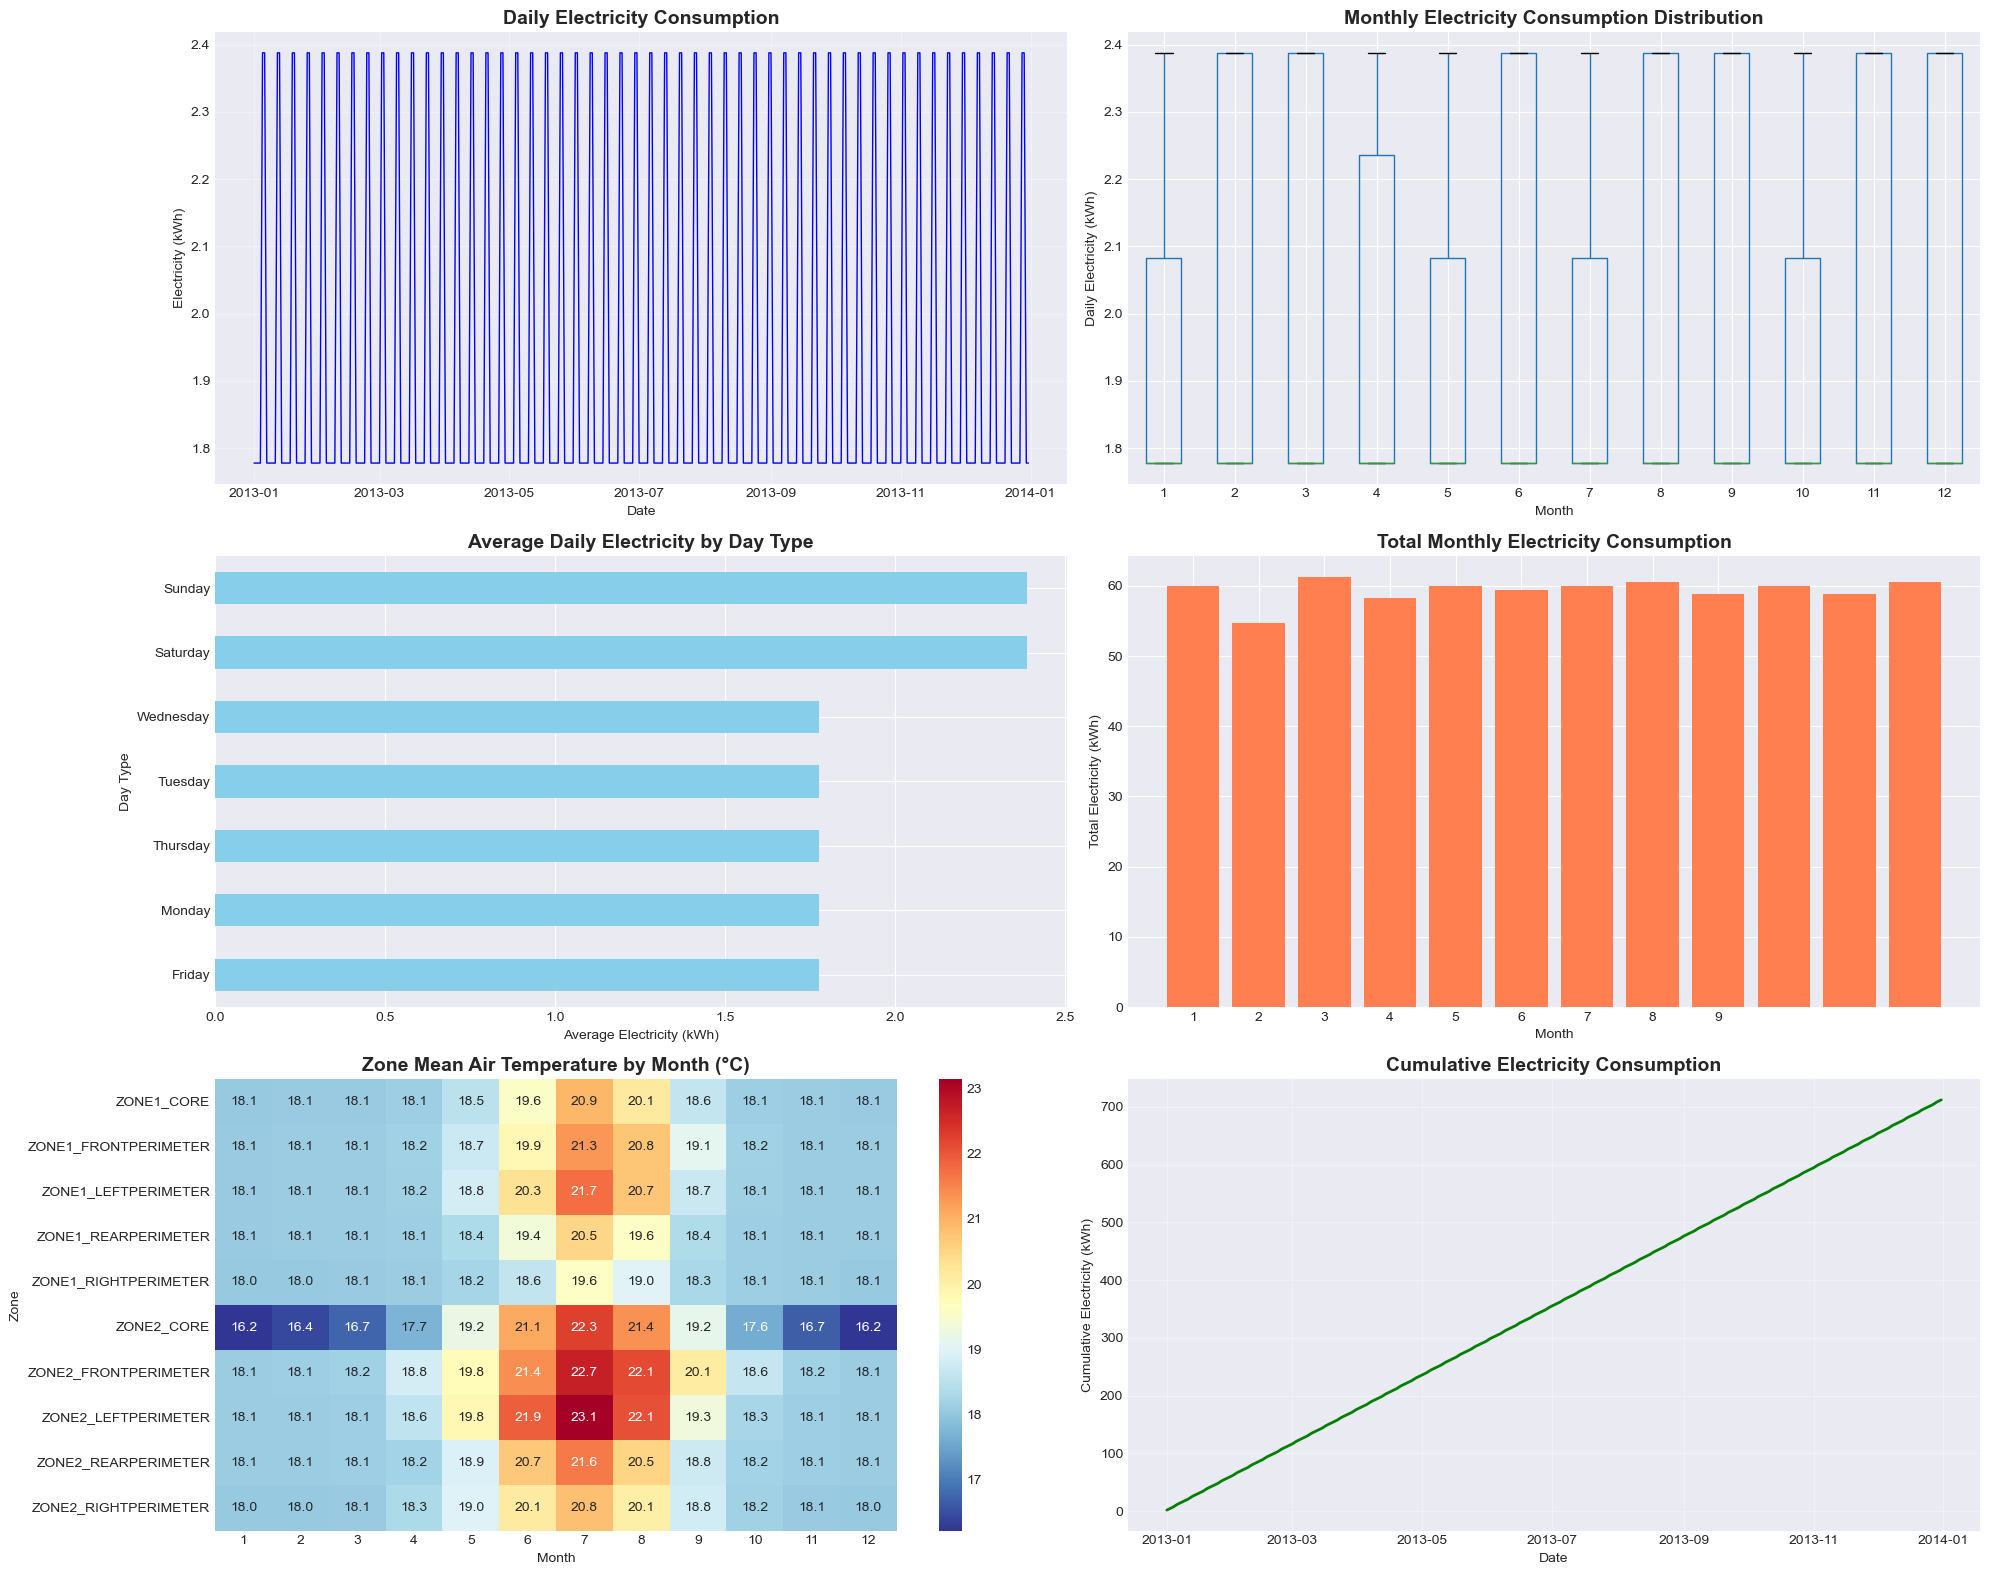

In [9]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Database path
db_path = r"D:\Documents\daily\E_Plus_2040_py\output\49d99568-e595-46aa-9fc0-22f0ddfdeb94\Sim_Results\2020\simulation_bldg0_4136733.sql"

# Connect to database
conn = sqlite3.connect(db_path)

print("ENERGYPLUS SIMULATION DATA ANALYSIS")
print("=" * 100)

# 1. ENERGY CONSUMPTION ANALYSIS
print("\n1. ENERGY CONSUMPTION ANALYSIS")
print("=" * 100)

# Get electricity consumption data
query_electricity = """
SELECT 
    t.Month, 
    t.Day,
    t.DayType,
    rd.Value / 1000000.0 as Electricity_MJ,
    rd.Value / 3600000.0 as Electricity_kWh
FROM ReportData rd
JOIN Time t ON rd.TimeIndex = t.TimeIndex
JOIN ReportDataDictionary rdd ON rd.ReportDataDictionaryIndex = rdd.ReportDataDictionaryIndex
WHERE rdd.Name = 'Electricity:Facility'
AND t.WarmupFlag IS NULL
ORDER BY t.Month, t.Day
"""

df_electricity = pd.read_sql_query(query_electricity, conn)
print(f"\nTotal simulation days with electricity data: {len(df_electricity)}")

# Monthly electricity consumption
monthly_elec = df_electricity.groupby('Month')['Electricity_kWh'].agg(['sum', 'mean', 'std', 'count'])
print("\nMonthly Electricity Consumption Summary:")
print(monthly_elec.round(2))

# Total consumption
total_electricity_kwh = df_electricity['Electricity_kWh'].sum()
print(f"\nTotal Electricity Consumption: {total_electricity_kwh:.2f} kWh")
print(f"Average Daily Consumption: {df_electricity['Electricity_kWh'].mean():.2f} kWh/day")

# 2. HEATING AND COOLING ENERGY
print("\n2. HEATING AND COOLING ENERGY ANALYSIS")
print("=" * 100)

# Get heating energy data
query_heating = """
SELECT 
    t.Month,
    t.Day,
    rd.Value / 1000000.0 as Heating_MJ,
    rd.Value / 3600000.0 as Heating_kWh
FROM ReportData rd
JOIN Time t ON rd.TimeIndex = t.TimeIndex
JOIN ReportDataDictionary rdd ON rd.ReportDataDictionaryIndex = rdd.ReportDataDictionaryIndex
WHERE rdd.Name = 'Heating:EnergyTransfer'
AND t.WarmupFlag IS NULL
ORDER BY t.Month, t.Day
"""

df_heating = pd.read_sql_query(query_heating, conn)

# Get cooling energy data
query_cooling = """
SELECT 
    t.Month,
    t.Day,
    rd.Value / 1000000.0 as Cooling_MJ,
    rd.Value / 3600000.0 as Cooling_kWh
FROM ReportData rd
JOIN Time t ON rd.TimeIndex = t.TimeIndex
JOIN ReportDataDictionary rdd ON rd.ReportDataDictionaryIndex = rdd.ReportDataDictionaryIndex
WHERE rdd.Name = 'Cooling:EnergyTransfer'
AND t.WarmupFlag IS NULL
ORDER BY t.Month, t.Day
"""

df_cooling = pd.read_sql_query(query_cooling, conn)

print(f"Days with heating data: {len(df_heating)}")
print(f"Days with cooling data: {len(df_cooling)}")

# 3. ZONE TEMPERATURE ANALYSIS
print("\n3. ZONE TEMPERATURE ANALYSIS")
print("=" * 100)

# Get all zone temperature data
query_zone_temps = """
SELECT 
    t.Month,
    t.Day,
    t.Hour,
    rdd.KeyValue as Zone,
    rdd.Name as Variable,
    rd.Value as Temperature_C
FROM ReportData rd
JOIN Time t ON rd.TimeIndex = t.TimeIndex
JOIN ReportDataDictionary rdd ON rd.ReportDataDictionaryIndex = rdd.ReportDataDictionaryIndex
WHERE rdd.Name IN ('Zone Mean Air Temperature', 'Zone Mean Radiant Temperature')
AND t.WarmupFlag IS NULL
AND rdd.ReportingFrequency = 'Monthly'
ORDER BY t.Month, rdd.KeyValue
"""

df_zone_temps = pd.read_sql_query(query_zone_temps, conn)

# Summary by zone
if len(df_zone_temps) > 0:
    zone_temp_summary = df_zone_temps.groupby(['Zone', 'Variable'])['Temperature_C'].agg(['mean', 'min', 'max', 'std'])
    print("\nZone Temperature Summary (°C):")
    print(zone_temp_summary.round(2))

# 4. OUTDOOR CONDITIONS
print("\n4. OUTDOOR CONDITIONS ANALYSIS")
print("=" * 100)

query_outdoor = """
SELECT 
    t.Month,
    t.Day,
    rdd.Name,
    rd.Value,
    rdd.Units
FROM ReportData rd
JOIN Time t ON rd.TimeIndex = t.TimeIndex
JOIN ReportDataDictionary rdd ON rd.ReportDataDictionaryIndex = rdd.ReportDataDictionaryIndex
WHERE rdd.Name IN ('Site Outdoor Air Drybulb Temperature', 
                   'Site Outdoor Air Relative Humidity',
                   'Site Diffuse Solar Radiation Rate per Area')
AND t.WarmupFlag IS NULL
ORDER BY t.Month, t.Day, rdd.Name
"""

df_outdoor = pd.read_sql_query(query_outdoor, conn)

# Pivot outdoor conditions
if len(df_outdoor) > 0:
    outdoor_summary = df_outdoor.groupby(['Month', 'Name'])['Value'].mean().reset_index()
    outdoor_pivot = outdoor_summary.pivot(index='Month', columns='Name', values='Value')
    print("\nMonthly Average Outdoor Conditions:")
    print(outdoor_pivot.round(2))

# 5. CREATE VISUALIZATIONS
print("\n5. CREATING VISUALIZATIONS")
print("=" * 100)

# Setup plotting
# Try to use seaborn style, fallback to default if not available
try:
    plt.style.use('seaborn-darkgrid')
except:
    try:
        plt.style.use('ggplot')
    except:
        pass  # Use default style

fig = plt.figure(figsize=(20, 16))

# Plot 1: Daily Electricity Consumption
ax1 = plt.subplot(3, 2, 1)
df_electricity['Date'] = pd.to_datetime('2013-' + df_electricity['Month'].astype(str) + '-' + df_electricity['Day'].astype(str))
ax1.plot(df_electricity['Date'], df_electricity['Electricity_kWh'], 'b-', linewidth=1)
ax1.set_title('Daily Electricity Consumption', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Electricity (kWh)')
ax1.grid(True, alpha=0.3)

# Plot 2: Monthly Electricity Box Plot
ax2 = plt.subplot(3, 2, 2)
df_electricity.boxplot(column='Electricity_kWh', by='Month', ax=ax2)
ax2.set_title('Monthly Electricity Consumption Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month')
ax2.set_ylabel('Daily Electricity (kWh)')
plt.suptitle('')  # Remove automatic title

# Plot 3: Energy by Day Type
ax3 = plt.subplot(3, 2, 3)
day_type_energy = df_electricity.groupby('DayType')['Electricity_kWh'].mean().sort_values()
day_type_energy.plot(kind='barh', ax=ax3, color='skyblue')
ax3.set_title('Average Daily Electricity by Day Type', fontsize=14, fontweight='bold')
ax3.set_xlabel('Average Electricity (kWh)')
ax3.set_ylabel('Day Type')

# Plot 4: Monthly Energy Summary
ax4 = plt.subplot(3, 2, 4)
monthly_total = df_electricity.groupby('Month')['Electricity_kWh'].sum()
ax4.bar(monthly_total.index, monthly_total.values, color='coral')
ax4.set_title('Total Monthly Electricity Consumption', fontsize=14, fontweight='bold')
ax4.set_xlabel('Month')
ax4.set_ylabel('Total Electricity (kWh)')
ax4.set_xticks(range(1, 10))

# Plot 5: Zone Temperature Heatmap (if data available)
ax5 = plt.subplot(3, 2, 5)
if len(df_zone_temps) > 0:
    # Create a pivot table for heatmap
    zone_air_temps = df_zone_temps[df_zone_temps['Variable'] == 'Zone Mean Air Temperature']
    if len(zone_air_temps) > 0:
        temp_pivot = zone_air_temps.pivot_table(values='Temperature_C', index='Zone', columns='Month', aggfunc='mean')
        sns.heatmap(temp_pivot, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=ax5)
        ax5.set_title('Zone Mean Air Temperature by Month (°C)', fontsize=14, fontweight='bold')
    else:
        ax5.text(0.5, 0.5, 'No zone temperature data available', ha='center', va='center', transform=ax5.transAxes)
else:
    ax5.text(0.5, 0.5, 'No zone temperature data available', ha='center', va='center', transform=ax5.transAxes)

# Plot 6: Cumulative Energy Consumption
ax6 = plt.subplot(3, 2, 6)
df_electricity_sorted = df_electricity.sort_values('Date')
df_electricity_sorted['Cumulative_kWh'] = df_electricity_sorted['Electricity_kWh'].cumsum()
ax6.plot(df_electricity_sorted['Date'], df_electricity_sorted['Cumulative_kWh'], 'g-', linewidth=2)
ax6.set_title('Cumulative Electricity Consumption', fontsize=14, fontweight='bold')
ax6.set_xlabel('Date')
ax6.set_ylabel('Cumulative Electricity (kWh)')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('energyplus_analysis.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'energyplus_analysis.png'")

# 6. DETAILED ZONE ANALYSIS
print("\n6. DETAILED ZONE ANALYSIS")
print("=" * 100)

# Get zone areas and volumes
query_zones = """
SELECT 
    ZoneName,
    FloorArea,
    Volume,
    ExtGrossWallArea,
    ExtWindowArea
FROM Zones
ORDER BY ZoneName
"""

df_zones = pd.read_sql_query(query_zones, conn)
print("\nZone Geometry Summary:")
print(df_zones.to_string())

# Calculate metrics
total_floor_area = df_zones['FloorArea'].sum()
total_volume = df_zones['Volume'].sum()
print(f"\nTotal Floor Area: {total_floor_area:.2f} m²")
print(f"Total Volume: {total_volume:.2f} m³")

# Energy intensity
if total_electricity_kwh > 0:
    energy_intensity = total_electricity_kwh / total_floor_area
    print(f"\nEnergy Use Intensity (EUI): {energy_intensity:.2f} kWh/m²")
    daily_eui = df_electricity['Electricity_kWh'].mean() / total_floor_area
    print(f"Average Daily EUI: {daily_eui:.2f} kWh/m²/day")

# 7. PEAK DEMAND ANALYSIS
print("\n7. PEAK DEMAND ANALYSIS")
print("=" * 100)

# Find peak consumption days
peak_days = df_electricity.nlargest(10, 'Electricity_kWh')[['Month', 'Day', 'DayType', 'Electricity_kWh']]
print("\nTop 10 Peak Electricity Consumption Days:")
print(peak_days.to_string())

# 8. SYSTEM SIZING INFORMATION
print("\n8. SYSTEM SIZING INFORMATION")
print("=" * 100)

query_sizing = """
SELECT 
    CompType,
    CompName,
    Description,
    Value,
    Units
FROM ComponentSizes
ORDER BY CompType, CompName
"""

df_sizing = pd.read_sql_query(query_sizing, conn)
print("\nHVAC Component Sizing:")
print(df_sizing.to_string())

# Close connection
conn.close()

print("\n" + "=" * 100)
print("Analysis complete!")
print("=" * 100)

# Create a summary report
print("\n\nEXECUTIVE SUMMARY")
print("=" * 100)
print(f"Building Type: 2-story office building")
print(f"Location: Netherlands (Lelystad)")
print(f"Simulation Period: January 1 - September 9, 2013 ({len(df_electricity)} days)")
print(f"Total Floor Area: {total_floor_area:.2f} m²")
print(f"Total Electricity Consumption: {total_electricity_kwh:.2f} kWh")
print(f"Average Daily Consumption: {df_electricity['Electricity_kWh'].mean():.2f} kWh/day")
print(f"Energy Use Intensity: {energy_intensity:.2f} kWh/m²")
print(f"Peak Daily Consumption: {df_electricity['Electricity_kWh'].max():.2f} kWh")
print(f"Minimum Daily Consumption: {df_electricity['Electricity_kWh'].min():.2f} kWh")

# Variable

In [10]:
import sqlite3
import pandas as pd
from pathlib import Path

# Database path
db_path = r"D:\Documents\daily\E_Plus_2040_py\output\49d99568-e595-46aa-9fc0-22f0ddfdeb94\Sim_Results\2020\simulation_bldg0_4136733.sql"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"Connected to: {Path(db_path).name}")
print("=" * 80)

# Query the ReportDataDictionary table to get all output variables
print("\nEXTRACTING OUTPUT VARIABLES FROM ReportDataDictionary")
print("=" * 80)

# Get all unique variable names
query = """
SELECT DISTINCT Name, Units, Type, IndexGroup
FROM ReportDataDictionary
ORDER BY Name
"""

df_variables = pd.read_sql_query(query, conn)

print(f"\nFound {len(df_variables)} unique output variables:")
print("-" * 80)

# Display all variables with their units and type
for idx, row in df_variables.iterrows():
    print(f"{idx+1:3d}. {row['Name']:<60} [{row['Units']:<10}] Type: {row['Type']}, Group: {row['IndexGroup']}")

# Group variables by IndexGroup
print("\n" + "=" * 80)
print("\nVARIABLES GROUPED BY INDEX GROUP:")
print("=" * 80)

grouped = df_variables.groupby('IndexGroup')
for group_name, group_df in grouped:
    print(f"\n{group_name} ({len(group_df)} variables):")
    print("-" * 40)
    for idx, row in group_df.iterrows():
        print(f"  - {row['Name']} [{row['Units']}]")

# Search for specific patterns
print("\n" + "=" * 80)
print("\nSEARCHING FOR SPECIFIC VARIABLE PATTERNS:")
print("=" * 80)

# Define search patterns
search_patterns = [
    ('heating', 'Heating-related variables'),
    ('cooling', 'Cooling-related variables'),
    ('ventilation', 'Ventilation-related variables'),
    ('surface', 'Surface-related variables'),
    ('conduction', 'Conduction-related variables'),
    ('temperature', 'Temperature-related variables'),
    ('energy', 'Energy-related variables'),
    ('electric', 'Electricity-related variables'),
    ('air', 'Air-related variables'),
    ('zone', 'Zone-related variables')
]

for pattern, description in search_patterns:
    query = f"""
    SELECT DISTINCT Name, Units, KeyValue
    FROM ReportDataDictionary
    WHERE LOWER(Name) LIKE '%{pattern}%'
    ORDER BY Name
    """
    
    df_pattern = pd.read_sql_query(query, conn)
    
    if len(df_pattern) > 0:
        print(f"\n{description} (containing '{pattern}'):")
        print("-" * 40)
        for idx, row in df_pattern.iterrows():
            key_info = f" (Key: {row['KeyValue']})" if row['KeyValue'] and row['KeyValue'] != 'None' else ""
            print(f"  - {row['Name']} [{row['Units']}]{key_info}")

# Get meter data separately
print("\n" + "=" * 80)
print("\nMETERS (IsMeter = 1):")
print("=" * 80)

query_meters = """
SELECT DISTINCT Name, Units
FROM ReportDataDictionary
WHERE IsMeter = 1
ORDER BY Name
"""

df_meters = pd.read_sql_query(query_meters, conn)

if len(df_meters) > 0:
    for idx, row in df_meters.iterrows():
        print(f"  - {row['Name']} [{row['Units']}]")
else:
    print("  No meters found.")

# Summary statistics
print("\n" + "=" * 80)
print("\nSUMMARY STATISTICS:")
print("=" * 80)

# Count by reporting frequency
query_freq = """
SELECT ReportingFrequency, COUNT(*) as Count
FROM ReportDataDictionary
GROUP BY ReportingFrequency
ORDER BY Count DESC
"""

df_freq = pd.read_sql_query(query_freq, conn)
print("\nVariables by Reporting Frequency:")
for idx, row in df_freq.iterrows():
    print(f"  - {row['ReportingFrequency']}: {row['Count']} variables")

# Count by Type
query_type = """
SELECT Type, COUNT(*) as Count
FROM ReportDataDictionary
GROUP BY Type
ORDER BY Count DESC
"""

df_type = pd.read_sql_query(query_type, conn)
print("\nVariables by Type:")
for idx, row in df_type.iterrows():
    print(f"  - {row['Type']}: {row['Count']} variables")

# Export to CSV for further analysis
output_file = "energyplus_output_variables.csv"
df_variables.to_csv(output_file, index=False)
print(f"\n\nAll unique variables exported to: {output_file}")

# Close connection
conn.close()
print("\nDatabase connection closed.")

Connected to: simulation_bldg0_4136733.sql

EXTRACTING OUTPUT VARIABLES FROM ReportDataDictionary

Found 41 unique output variables:
--------------------------------------------------------------------------------
  1. Cooling:EnergyTransfer                                       [J         ] Type: Sum, Group: Facility:EnergyTransfer:Cooling
  2. Electricity:Facility                                         [J         ] Type: Sum, Group: Facility:Electricity
  3. Heating:EnergyTransfer                                       [J         ] Type: Sum, Group: Facility:EnergyTransfer:Heating
  4. Site Diffuse Solar Radiation Rate per Area                   [W/m2      ] Type: Avg, Group: Zone
  5. Site Outdoor Air Drybulb Temperature                         [C         ] Type: Avg, Group: Zone
  6. Site Outdoor Air Relative Humidity                           [%         ] Type: Avg, Group: Zone
  7. Surface Inside Face Conduction Heat Transfer Rate            [W         ] Type: Avg, Group: Zone
  

In [11]:
import sqlite3
import pandas as pd
from pathlib import Path

# Database path
db_path = r"D:\Documents\daily\E_Plus_2040_py\output\49d99568-e595-46aa-9fc0-22f0ddfdeb94\Sim_Results\2020\simulation_bldg0_4136733.sql"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"Connected to: {Path(db_path).name}")
print("=" * 80)

# Query the ReportDataDictionary table to get all output variables
print("\nALL UNIQUE OUTPUT VARIABLES FROM ReportDataDictionary")
print("=" * 80)

# Get all unique variable names
query = """
SELECT DISTINCT Name, Units, Type, IndexGroup, IsMeter
FROM ReportDataDictionary
ORDER BY Name
"""

df_variables = pd.read_sql_query(query, conn)

print(f"\nFound {len(df_variables)} unique output variables:\n")
print("-" * 120)
print(f"{'#':>4} {'Variable Name':<70} {'Units':<15} {'Type':<10} {'Group':<20} {'Meter':<5}")
print("-" * 120)

# Display all variables with their details
for idx, row in df_variables.iterrows():
    meter_flag = "Yes" if row['IsMeter'] == 1 else "No"
    print(f"{idx+1:4d} {row['Name']:<70} {row['Units']:<15} {row['Type']:<10} {row['IndexGroup']:<20} {meter_flag:<5}")

# Group count summary
print("\n" + "=" * 80)
print("SUMMARY BY INDEX GROUP:")
print("=" * 80)

group_counts = df_variables.groupby('IndexGroup').size().sort_values(ascending=False)
for group, count in group_counts.items():
    print(f"{group:<30} {count:>5} variables")

# Export to CSV for further analysis
output_file = "energyplus_all_output_variables.csv"
df_variables.to_csv(output_file, index=False)
print(f"\n\nAll unique variables exported to: {output_file}")

# Also create a simple text file with just the variable names
with open("energyplus_variable_names.txt", "w") as f:
    f.write("EnergyPlus Output Variables List\n")
    f.write("=" * 80 + "\n\n")
    for idx, row in df_variables.iterrows():
        f.write(f"{idx+1}. {row['Name']} [{row['Units']}]\n")

print(f"Variable names also saved to: energyplus_variable_names.txt")

# Close connection
conn.close()
print("\nDatabase connection closed.")

Connected to: simulation_bldg0_4136733.sql

ALL UNIQUE OUTPUT VARIABLES FROM ReportDataDictionary

Found 41 unique output variables:

------------------------------------------------------------------------------------------------------------------------
   # Variable Name                                                          Units           Type       Group                Meter
------------------------------------------------------------------------------------------------------------------------
   1 Cooling:EnergyTransfer                                                 J               Sum        Facility:EnergyTransfer:Cooling Yes  
   2 Electricity:Facility                                                   J               Sum        Facility:Electricity Yes  
   3 Heating:EnergyTransfer                                                 J               Sum        Facility:EnergyTransfer:Heating Yes  
   4 Site Diffuse Solar Radiation Rate per Area                             W/m2  

In [12]:
import sqlite3
import pandas as pd
from pathlib import Path

# Database path
db_path = r"D:\Documents\daily\E_Plus_2040_py\output\49d99568-e595-46aa-9fc0-22f0ddfdeb94\Sim_Results\2020\simulation_bldg0_4136733.sql"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"Connected to: {Path(db_path).name}")
print("=" * 80)

# Query to get all variables and check if they have data
print("\nANALYZING ALL OUTPUT VARIABLES (Requested vs Generated)")
print("=" * 80)

# Get all variables from dictionary with data availability check
query = """
SELECT 
    rdd.ReportDataDictionaryIndex,
    rdd.Name,
    rdd.Units,
    rdd.Type,
    rdd.IndexGroup,
    rdd.KeyValue,
    rdd.ReportingFrequency,
    rdd.IsMeter,
    COUNT(rd.ReportDataIndex) as DataCount
FROM ReportDataDictionary rdd
LEFT JOIN ReportData rd ON rdd.ReportDataDictionaryIndex = rd.ReportDataDictionaryIndex
GROUP BY rdd.ReportDataDictionaryIndex, rdd.Name, rdd.Units, rdd.Type, 
         rdd.IndexGroup, rdd.KeyValue, rdd.ReportingFrequency, rdd.IsMeter
ORDER BY rdd.Name, rdd.KeyValue
"""

df_all = pd.read_sql_query(query, conn)

# Separate variables with data and without data
df_with_data = df_all[df_all['DataCount'] > 0].copy()
df_no_data = df_all[df_all['DataCount'] == 0].copy()

print(f"\nTotal variables in dictionary: {len(df_all)}")
print(f"Variables WITH data: {len(df_with_data)}")
print(f"Variables WITHOUT data (requested but not generated): {len(df_no_data)}")

# Display variables WITH data
print("\n" + "=" * 80)
print("VARIABLES WITH DATA (Successfully Generated):")
print("=" * 80)
print(f"{'#':>4} {'Variable Name':<60} {'Key':<25} {'Units':<10} {'Type':<5} {'Group':<15} {'Records':<10}")
print("-" * 140)

for idx, row in df_with_data.iterrows():
    key_display = str(row['KeyValue'])[:23] + '..' if len(str(row['KeyValue'])) > 25 else str(row['KeyValue'])
    print(f"{idx+1:4d} {row['Name']:<60} {key_display:<25} {row['Units']:<10} {row['Type']:<5} {row['IndexGroup']:<15} {row['DataCount']:<10d}")

# Display variables WITHOUT data
if len(df_no_data) > 0:
    print("\n" + "=" * 80)
    print("VARIABLES WITHOUT DATA (Requested but Not Generated):")
    print("=" * 80)
    print(f"{'#':>4} {'Variable Name':<60} {'Key':<25} {'Units':<10} {'Type':<5} {'Group':<15} {'Frequency':<15}")
    print("-" * 150)
    
    for idx, row in df_no_data.iterrows():
        key_display = str(row['KeyValue'])[:23] + '..' if len(str(row['KeyValue'])) > 25 else str(row['KeyValue'])
        print(f"{idx+1:4d} {row['Name']:<60} {key_display:<25} {row['Units']:<10} {row['Type']:<5} {row['IndexGroup']:<15} {row['ReportingFrequency']:<15}")

# Get unique variable names (regardless of key)
print("\n" + "=" * 80)
print("UNIQUE VARIABLE NAMES SUMMARY:")
print("=" * 80)

unique_vars = df_all.groupby('Name').agg({
    'Units': 'first',
    'Type': 'first',
    'IndexGroup': 'first',
    'DataCount': lambda x: (x > 0).sum(),  # Count of keys with data
    'ReportDataDictionaryIndex': 'count'   # Total count of keys
}).reset_index()

unique_vars.columns = ['Name', 'Units', 'Type', 'IndexGroup', 'Keys_with_Data', 'Total_Keys']
unique_vars['All_Keys_Have_Data'] = unique_vars['Keys_with_Data'] == unique_vars['Total_Keys']

print(f"\nTotal unique variable names: {len(unique_vars)}")
print(f"Variables where ALL keys have data: {unique_vars['All_Keys_Have_Data'].sum()}")
print(f"Variables where SOME keys missing data: {(~unique_vars['All_Keys_Have_Data'] & (unique_vars['Keys_with_Data'] > 0)).sum()}")
print(f"Variables where NO keys have data: {(unique_vars['Keys_with_Data'] == 0).sum()}")

# Export detailed results
df_all['Has_Data'] = df_all['DataCount'] > 0
df_all.to_csv("energyplus_variables_detailed.csv", index=False)
print(f"\n\nDetailed results exported to: energyplus_variables_detailed.csv")

# Export summary of missing variables
if len(df_no_data) > 0:
    df_no_data.to_csv("energyplus_missing_variables.csv", index=False)
    print(f"Missing variables exported to: energyplus_missing_variables.csv")

# Create summary text file
with open("energyplus_variables_summary.txt", "w") as f:
    f.write("EnergyPlus Output Variables Analysis\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Total variables in dictionary: {len(df_all)}\n")
    f.write(f"Variables WITH data: {len(df_with_data)}\n")
    f.write(f"Variables WITHOUT data: {len(df_no_data)}\n\n")
    
    if len(df_no_data) > 0:
        f.write("MISSING VARIABLES (Requested but not generated):\n")
        f.write("-" * 80 + "\n")
        for idx, row in df_no_data.iterrows():
            f.write(f"{row['Name']} [{row['Units']}] - Key: {row['KeyValue']}\n")

print(f"Summary saved to: energyplus_variables_summary.txt")

# Close connection
conn.close()
print("\nDatabase connection closed.")

Connected to: simulation_bldg0_4136733.sql

ANALYZING ALL OUTPUT VARIABLES (Requested vs Generated)

Total variables in dictionary: 476
Variables WITH data: 476
Variables WITHOUT data (requested but not generated): 0

VARIABLES WITH DATA (Successfully Generated):
   # Variable Name                                                Key                       Units      Type  Group           Records   
--------------------------------------------------------------------------------------------------------------------------------------------
   1 Cooling:EnergyTransfer                                       None                      J          Sum   Facility:EnergyTransfer:Cooling 12        
   2 Electricity:Facility                                         None                      J          Sum   Facility:Electricity 365       
   3 Heating:EnergyTransfer                                       None                      J          Sum   Facility:EnergyTransfer:Heating 12        
   4 Site Diff